###  앙상블 학습

* 앙상블 학습의 유형은 보팅, 배깅, 부스팅 세가지로 나눌 수 있으며 이외에도 스태깅을 포함한 다양한 앙상블 방법이 있다.
* 보팅의 경우 서로 다른 알고리즘을 가진 분류기를 결합하는 것이고 배깅의 경우 각각의 분류기가 모두 같은 유형의 알고리즘 기반이다.
* 정형 데이터의 예측 분석 영역에서는 매우 높은 예측 성능. 
* 배깅 방식의 대표인 Random Forest는 뛰어난 예측 성능, 상대적으로 빠른 수행시간, 유연성 등으로 애용.
* 부스팅의 효시는 Gradient Boosting, 한 단계 발전시키면서도 시간 단축시킨 XgBoost, LightGBM이 정형 데이터의 분류 영역에서 
  활용도 확대
* 앙상블의 앙상블이라고 불리는 스태킹 기법
* 앙상블의 기본 알고리즘은 결정 트리


### Voting Classifier
- 하드 보팅 : 다수결 원칙, 다수의 분류기가 결정한 예측값을 최종 보팅 결과값으로 선정
- 소프트 보팅 : 분류기들의 레이블 값 결정 확률을 모두 더해서 평균하고 이들 중 가장 높은 레이블 값을 최종 보팅 결과값으로 선정


In [1]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
cancer = load_breast_cancer()


In [4]:
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)], voting='soft')

X_train,X_test,y_train,y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

vo_clf.fit(X_train,y_train)
pred = vo_clf.predict(X_test)
print(f'Voting 정확도: {round(accuracy_score(y_test,pred),4)}')

classifiers = [lr_clf,knn_clf]
for classifier in classifiers:
    classifier.fit(X_train,y_train)
    pred = classifier.predict(X_test)
    class_name=classifier.__class__.__name__
    print(f'{class_name} 정확도: {round(accuracy_score(y_test,pred),4)}')

Voting 정확도: 0.9474
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386


#### Random Forest

https://eunsukimme.github.io/ml/2019/11/26/Random-Forest/



In [1]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df


In [7]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

# 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()


In [9]:
feature_name_df = pd.read_csv('human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
new_feature_name_df = get_new_feature_name_df(feature_name_df)
print(new_feature_name_df.shape)
new_feature_name_df.head()

(561, 3)


,column_index,column_name,dup_cnt
0,1,tBodyAcc-mean()-X,0
1,2,tBodyAcc-mean()-Y,0
2,3,tBodyAcc-mean()-Z,0
3,4,tBodyAcc-std()-X,0
4,5,tBodyAcc-std()-Y,0


In [10]:
fdd = new_feature_name_df.groupby('column_name').count()
fdd[fdd.column_index > 1].count()

column_index    0
dup_cnt         0
dtype: int64

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'랜덤포레스트 정확도: {round(accuracy,4)}')

랜덤포레스트 정확도: 0.9253


In [14]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train,y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print(f'최고 예측 정확도: {round(grid_cv.best_score_,4)}')

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.918


과제_0921_1.

수작업으로 하이퍼 파라미터를 3가지 유형으로 변환하여 모델 학습 후 평가 결과를 비교하세요.

In [ ]:
rf_clf = RandomForestClassifier(n_estimators = 100, max_depth=10, min_samples_leaf=8, \
                                min_samples_split = 8, random_state=0 )

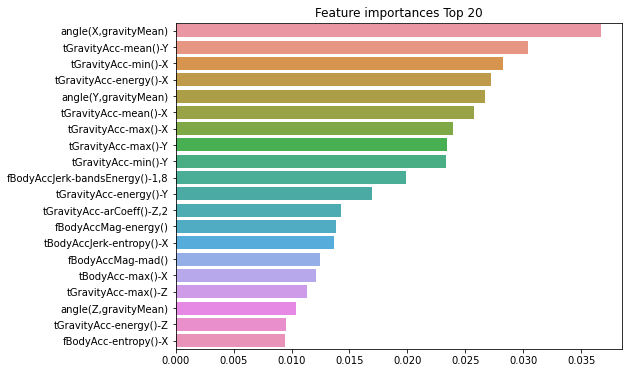

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

best_df_clf = grid_cv.best_estimator_
ftr_importances_values = best_df_clf.feature_importances_

# ftr_importances_values = grid_cv.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

## GBM(Gradient Boosting Machine)
- 부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 가중치 업데이트를 경사 하강법(Gradient Descent)를 이용한다.
- 분류는 물론이고 회귀도 가능
- 파라미터 : n_estimators, max_depth, max_features
 - loss : 경사하강법에서 사용할 비용함수 지정. 기본값 deviance 적용
 - learning_rate : GBM이 학습할 때마다 적용할 학습률.오류값 보정 시 적용하는 계수로 0 ~ 1 사이의 값 지정. 기본값은 0.1. 작게 설정하면 예측성능이 높아지나 수행시간이 오래 걸리고 큰 값을 적용하면 예측 성능이 떨어질 가능성이 높으나 빠른 수행이 가능. n_estimator와 상호 보완적으로 조합해 사용
 - n_estimator : weak learner의 개수
 - subsample : weak learner가 학습에 사용하는 데이터의 샘플링 비율. 기본값은 1


In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

X_train,X_test, y_train, y_test = get_human_dataset()
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test,gb_pred)

print(f'GBM 정확도:{round(gb_accuracy,4)}')
print(f'수행시간: {round(time.time()-start_time)}')

GBM 정확도:0.9389
수행시간: 484


과제_0921_2.(주의 : 30 ~ 1시간 소요)

위 문제에 대하여 성능 개선을 수행하세요.

In [ ]:
params = { 
    'n_estimators':[100,500],
    'learning_rate':[0.05,0.1]
}